In [1]:
from Reduced_functions import *
import matplotlib.pyplot as plt
#from matplotlib.animation import FuncAnimation
import numpy as np
#from Functions import *
from skimage.metrics import structural_similarity as ssim
#import itertools
import os

# Load all data

In [2]:
# Go up one folder
os.chdir('..')
# Go down to the data folder
os.chdir('Data')
# Load the data
MPS_data = np.load('ragnar_data.npy')
TGRF_data = np.load('TGRF_data.npy')
TGRF_data_small = np.load('TGRF_data_small.npy')
TGRF_data_complex = np.load('TGRF_data_complex.npy')
curved_straight_data = np.load('curved_straight_images.npz')
# Get the curved and straight separately
curved_data = curved_straight_data['curved']
straight_data = curved_straight_data['straight']
contact_gap_images = np.load('contact_gap_images.npz')
contact_images = contact_gap_images['contact']
gap_images = contact_gap_images['gap']
# remove index 5,12,16,42,46 from contact and gap images
contact_images = np.delete(contact_images, [5,12,16,42,46], axis=0)
gap_images = np.delete(gap_images, [5,12,16,42,46], axis=0)

# Plot the 5 first images of each dataset

In [3]:
all_data = [MPS_data, TGRF_data, TGRF_data_small, TGRF_data_complex, curved_data, straight_data, contact_images, gap_images]
# Remove all images that contains only zeros

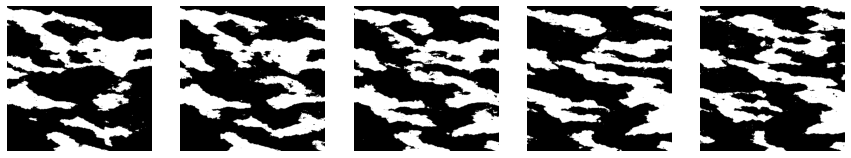

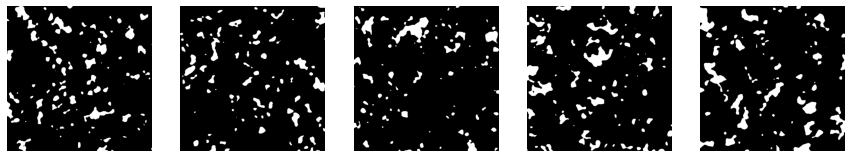

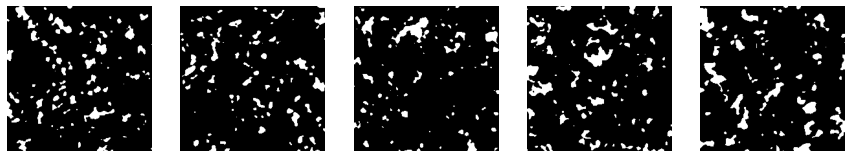

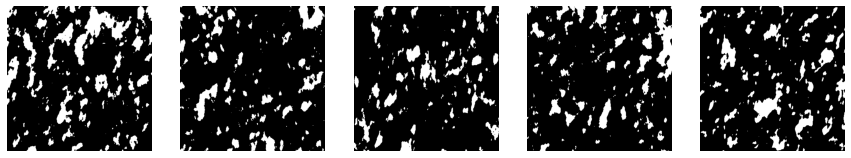

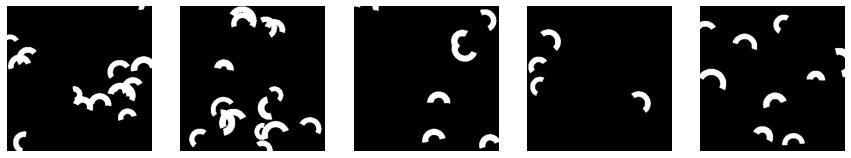

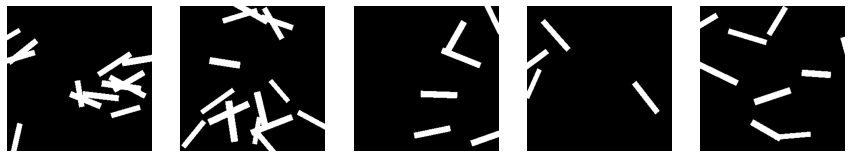

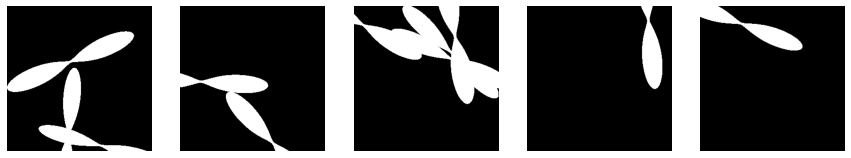

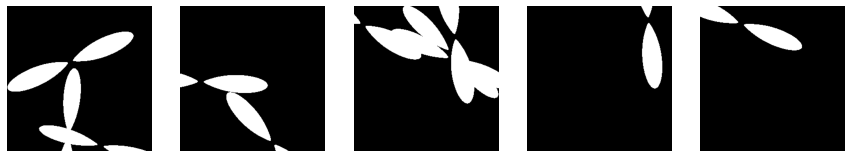

In [4]:
for data in all_data:
    fig, ax = plt.subplots(1, 5, figsize=(15, 3))
    for i in range(5):
        ax[i].imshow(data[i], cmap='gray')
        ax[i].axis('off')
    plt.show()

# Compute Anchor Vectors and show

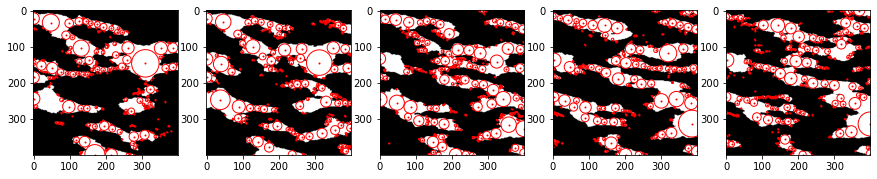

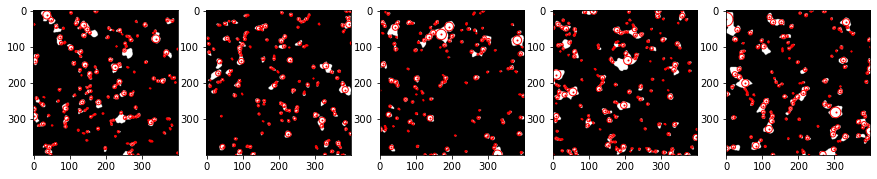

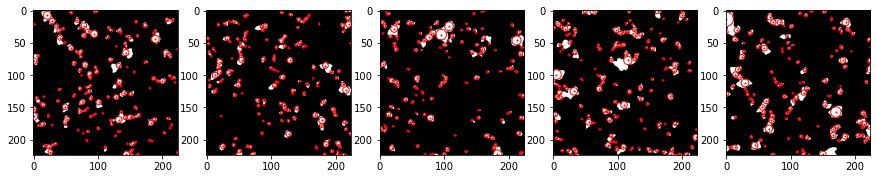

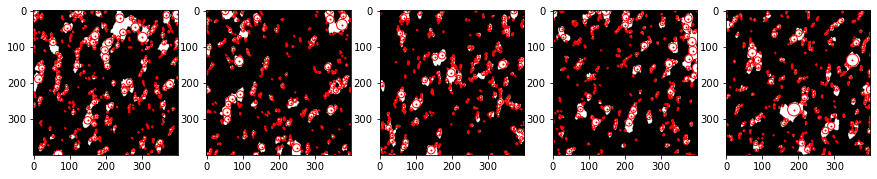

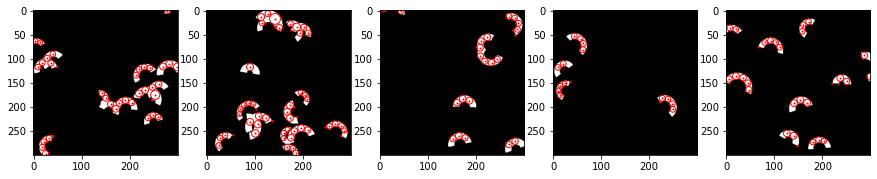

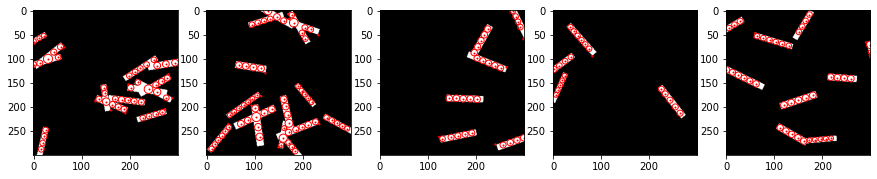

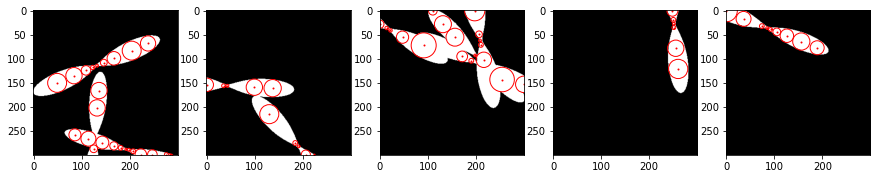

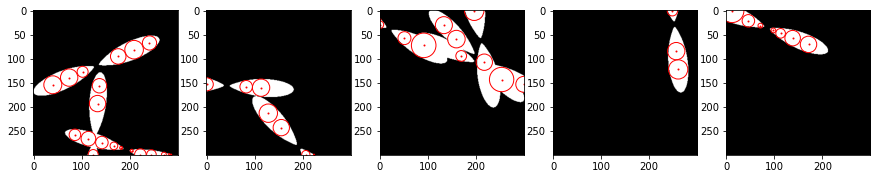

In [5]:
all_anchors = []
all_vectors = []
for data in all_data:
    anchors = []
    vectors = []
    for i in range(len(data)):
        anchors.append(find_local_maxima(data[i], allow_ties=True))
        vectors.append(oscar_ragnar_vec(data[i]))
    all_anchors.append(anchors)
    all_vectors.append(vectors)

for j in range(len(all_data)):
    fig, ax = plt.subplots(1, 5, figsize=(15, 3))
    for i in range(5):
        ax[i].imshow(all_data[j][i], cmap='gray')
        for x, y, r in all_anchors[j][i]:
            ax[i].plot(y, x, 'ro', markersize=1)
            ax[i].add_artist(plt.Circle((y, x), r, color='r', fill=False))
    plt.show()

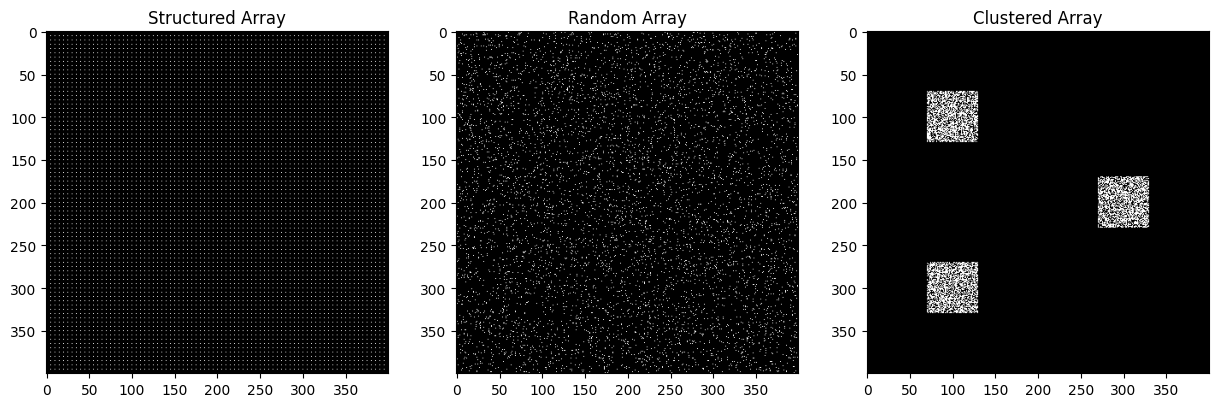

In [73]:
import numpy as np
import matplotlib.pyplot as plt

# Define the size of the array
size = 400

# 1. Structured Binary Array
structured_array = np.zeros((size, size), dtype=int)
for i in range(0, size, 5):
    for j in range(0, size, 5):
        structured_array[i, j] = 1

# 2. Random Binary Array
num_ones = np.sum(structured_array)  # Total number of 1s in the structured array
random_array = np.zeros((size, size), dtype=int)
random_indices = np.random.choice(size*size, num_ones, replace=False)
random_array[np.unravel_index(random_indices, (size, size))] = 1

# 3. Clustered Binary Array
clustered_array = np.zeros((size, size), dtype=int)

# Define 3 clusters (center points and radii)
clusters = [
    ((100, 100), 30),
    ((300, 100), 30),
    ((200, 300), 30)
]

def add_cluster(array, center, radius, num_points):
    cx, cy = center
    points_added = 0
    while points_added < num_points:
        x = np.random.randint(max(0, cx - radius), min(size, cx + radius))
        y = np.random.randint(max(0, cy - radius), min(size, cy + radius))
        if array[x, y] == 0:
            array[x, y] = 1
            points_added += 1

# Add clusters
points_per_cluster = num_ones // 3
for center, radius in clusters:
    add_cluster(clustered_array, center, radius, points_per_cluster)

# Ensure the remaining points (if any) are added
remaining_points = num_ones - points_per_cluster * 3
add_cluster(clustered_array, clusters[0][0], clusters[0][1], remaining_points)

# Plot the arrays
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(structured_array, cmap='gray')
axs[0].set_title('Structured Array')
axs[1].imshow(random_array, cmap='gray')
axs[1].set_title('Random Array')
axs[2].imshow(clustered_array, cmap='gray')
axs[2].set_title('Clustered Array')
plt.show()



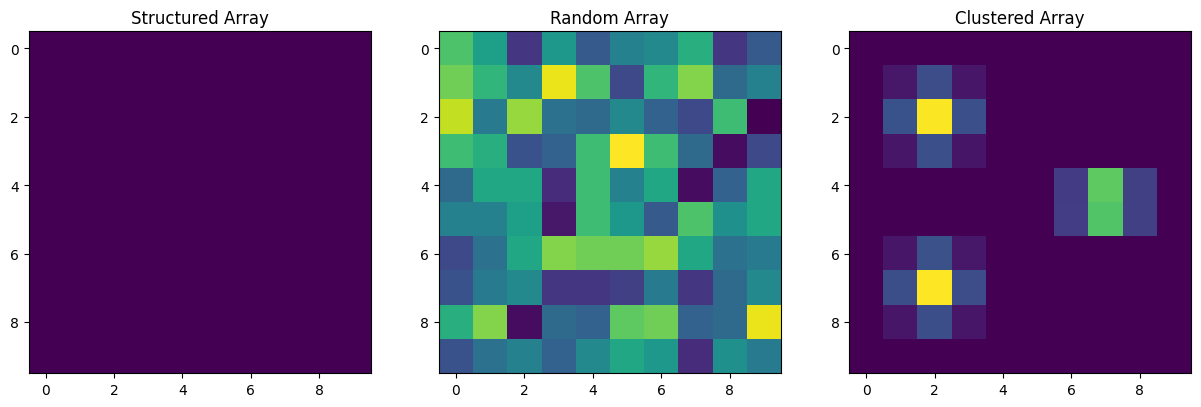

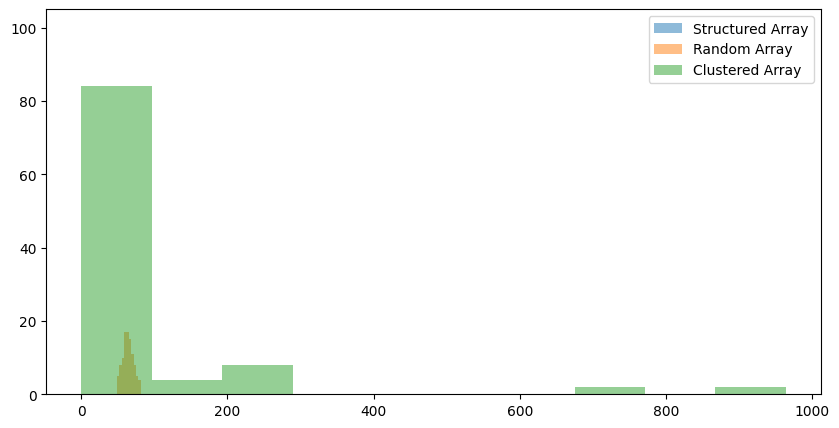

In [77]:
vert_size = 40
hor_size = 40
quadrants_count_structured = np.zeros((10, 10))
quadrants_count_random = np.zeros((10, 10))
quadrants_count_clustered = np.zeros((10, 10))
for i in range(10):
    for j in range(10):
        quadrants_count_structured[i, j] = np.sum(structured_array[i*vert_size:(i+1)*vert_size, j*hor_size:(j+1)*hor_size])
        quadrants_count_random[i, j] = np.sum(random_array[i*vert_size:(i+1)*vert_size, j*hor_size:(j+1)*hor_size])
        quadrants_count_clustered[i, j] = np.sum(clustered_array[i*vert_size:(i+1)*vert_size, j*hor_size:(j+1)*hor_size])

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(quadrants_count_structured, cmap='viridis')
axs[0].set_title('Structured Array')
axs[1].imshow(quadrants_count_random, cmap='viridis')
axs[1].set_title('Random Array')
axs[2].imshow(quadrants_count_clustered, cmap='viridis')
axs[2].set_title('Clustered Array')
plt.show()
# Show histograms in a single plot
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.hist(quadrants_count_structured.flatten(), alpha=0.5, label='Structured Array')
ax.hist(quadrants_count_random.flatten(),  alpha=0.5, label='Random Array')
ax.hist(quadrants_count_clustered.flatten(), alpha=0.5, label='Clustered Array')
ax.legend()
plt.show()

In [78]:
def calculate_statistics(counts):
    mean_count = np.mean(counts)
    var_count = np.var(counts)
    return mean_count, var_count

def count_ones_in_subgrids(binary_array, subgrid_size=10):
    rows, cols = binary_array.shape
    counts = []
    for i in range(0, rows, subgrid_size):
        for j in range(0, cols, subgrid_size):
            subgrid = binary_array[i:i+subgrid_size, j:j+subgrid_size]
            counts.append(np.sum(subgrid))
    return np.array(counts)

def construct_metric(binary_array, subgrid_size=10):
    counts = count_ones_in_subgrids(binary_array, subgrid_size)
    mean_count, var_count = calculate_statistics(counts)
    
    # Expected mean and variance for a random distribution
    total_cells = subgrid_size * subgrid_size
    p = np.mean(binary_array)  # Proportion of 1s in the entire array
    expected_mean = total_cells * p
    expected_variance = total_cells * p * (1 - p)
    
    # Normalize the variance to be between -1 and 1
    metric = (var_count - expected_variance) / (var_count + expected_variance)
    
    # Bound the metric between -1 and 1
    if metric > 1:
        metric = 1
    elif metric < -1:
        metric = -1
    
    return metric

In [80]:
def oscar_ragnar_vec(image):
    local_max_with_radii = find_local_maxima(image, allow_ties=True)
    vec = np.zeros(4)
    grid_size = image.shape[0]*image.shape[1]
    vec[0] = len(local_max_with_radii)
    vec[1] = np.mean([x[2]/grid_size for x in local_max_with_radii])
    vec[2] = np.std([x[2]/grid_size for x in local_max_with_radii])
    anchor_pic = np.zeros_like(image)
    for x, y, r in local_max_with_radii:
        anchor_pic[x, y] = 1
    vec[3] = construct_metric(anchor_pic)
    return vec

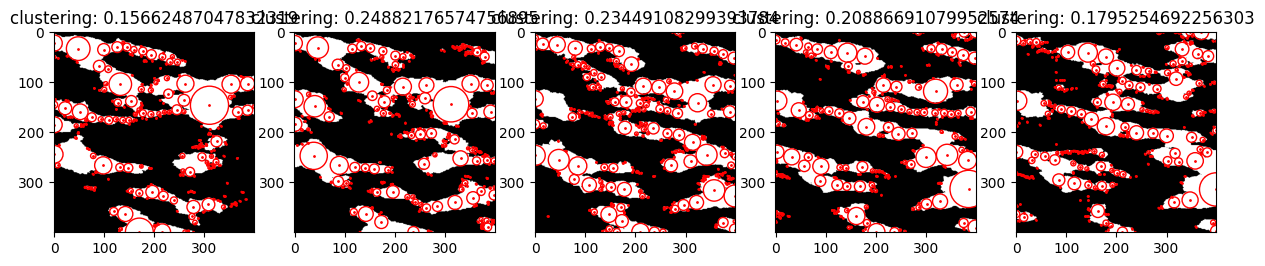

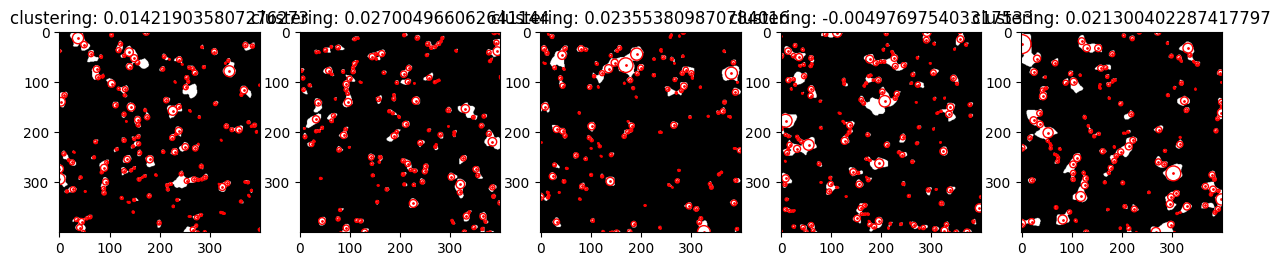

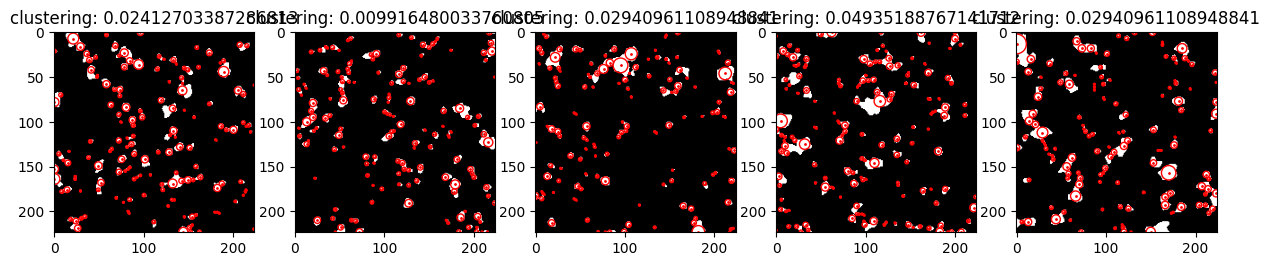

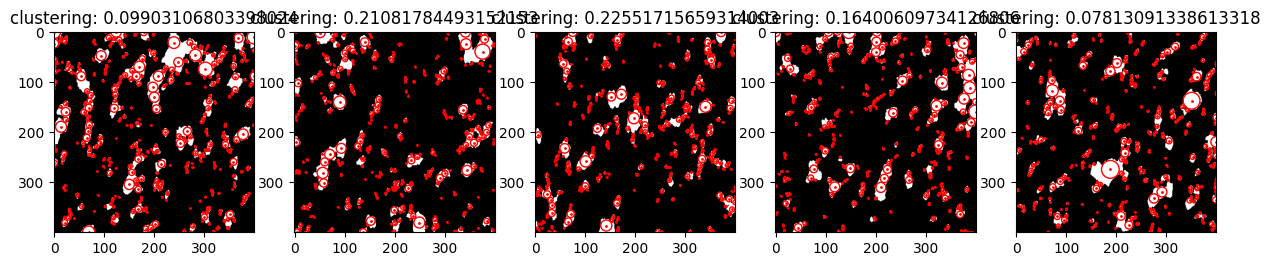

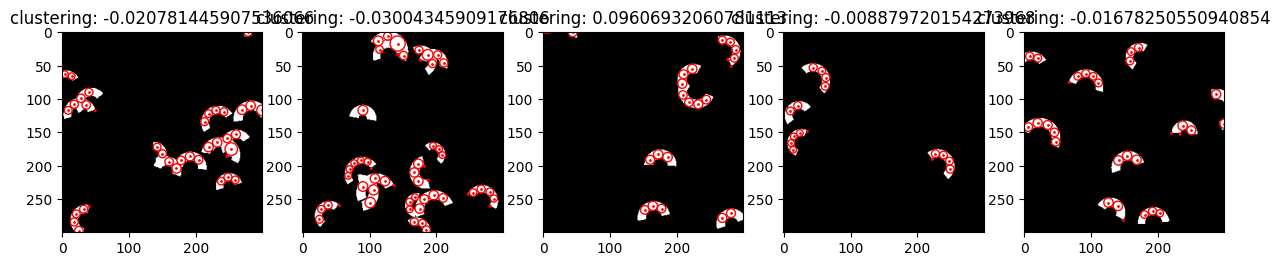

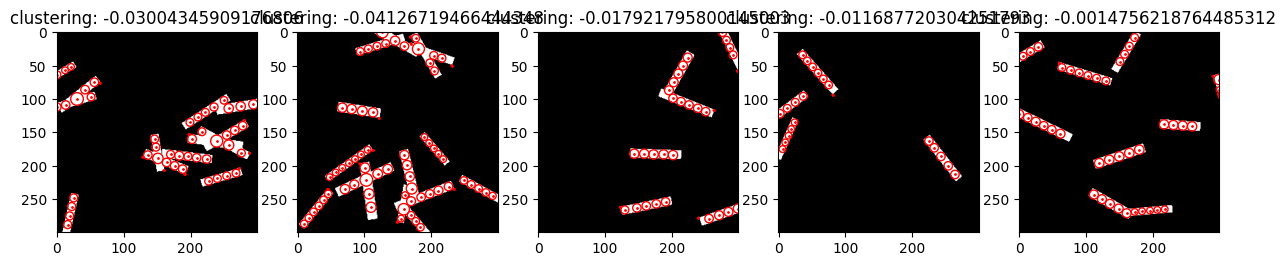

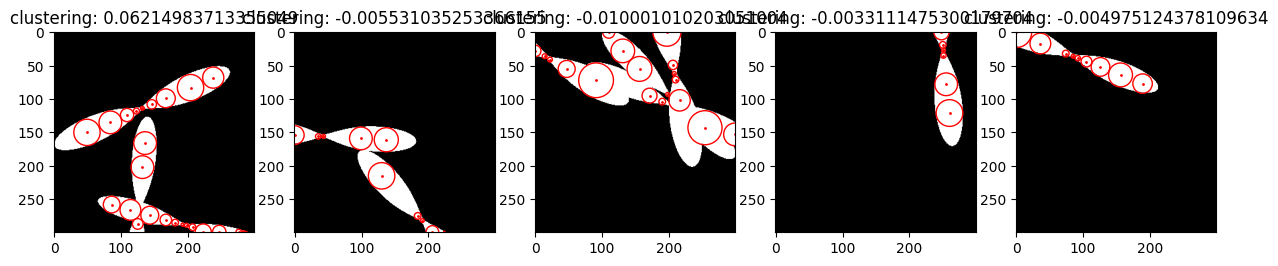

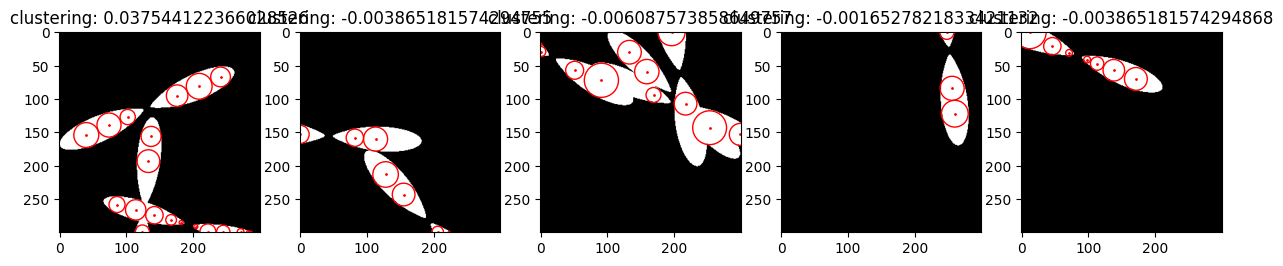

In [82]:
all_anchors = []
all_vectors = []
for data in all_data:
    anchors = []
    vectors = []
    for i in range(len(data)):
        anchors.append(find_local_maxima(data[i], allow_ties=True))
        vectors.append(oscar_ragnar_vec(data[i]))
    all_anchors.append(anchors)
    all_vectors.append(vectors)

for j in range(len(all_data)):
    fig, ax = plt.subplots(1, 5, figsize=(15, 3))
    for i in range(5):
        ax[i].imshow(all_data[j][i], cmap='gray')
        for x, y, r in all_anchors[j][i]:
            ax[i].plot(y, x, 'ro', markersize=1)
            ax[i].add_artist(plt.Circle((y, x), r, color='r', fill=False))
        ax[i].set_title(f'clustering: {all_vectors[j][i][3]}')
    plt.show()

In [79]:
# Create the binary arrays as described in the previous steps
size = 400

# 1. Structured Binary Array
structured_array = np.zeros((size, size), dtype=int)
for i in range(0, size, 5):
    for j in range(0, size, 5):
        structured_array[i, j] = 1

# 2. Random Binary Array
num_ones = np.sum(structured_array)
random_array = np.zeros((size, size), dtype=int)
random_indices = np.random.choice(size*size, num_ones, replace=False)
random_array[np.unravel_index(random_indices, (size, size))] = 1

# 3. Clustered Binary Array
clustered_array = np.zeros((size, size), dtype=int)
clusters = [
    ((100, 100), 30),
    ((300, 100), 30),
    ((200, 300), 30)
]

def add_cluster(array, center, radius, num_points):
    cx, cy = center
    points_added = 0
    while points_added < num_points:
        x = np.random.randint(max(0, cx - radius), min(size, cx + radius))
        y = np.random.randint(max(0, cy - radius), min(size, cy + radius))
        if array[x, y] == 0:
            array[x, y] = 1
            points_added += 1

points_per_cluster = num_ones // 3
for center, radius in clusters:
    add_cluster(clustered_array, center, radius, points_per_cluster)
remaining_points = num_ones - points_per_cluster * 3
add_cluster(clustered_array, clusters[0][0], clusters[0][1], remaining_points)

# Calculate the metric for each array
structured_metric = construct_metric(structured_array)
random_metric = construct_metric(random_array)
clustered_metric = construct_metric(clustered_array)

print(f'Structured Metric: {structured_metric}')
print(f'Random Metric: {random_metric}')
print(f'Clustered Metric: {clustered_metric}')

# Expected output:
# Structured Metric: Close to -1
# Random Metric: Close to 0
# Clustered Metric: Close to 1

Structured Metric: -1.0
Random Metric: -0.01436354631005444
Clustered Metric: 0.9660872877005702


In [12]:
image_paths_MPS = []
image_paths_TGRF = []
image_paths_TGRF_small = []
image_paths_TGRF_complex = []
image_paths_curved = []
image_paths_straight = []
image_paths_gap = []
image_paths_contact = []
os.chdir('..')
os.chdir('Binary_images')
for i in range(50):
    image_paths_MPS.append(os.path.join(os.getcwd(),'ragnar_data' + str(i) + '.png'))
    image_paths_TGRF.append(os.path.join(os.getcwd(),'TGRF_data' + str(i) + '.png'))
    image_paths_TGRF_small.append(os.path.join(os.getcwd(),'TGRF_data_small' + str(i) + '.png'))
    image_paths_TGRF_complex.append(os.path.join(os.getcwd(),'TGRF_complex' + str(i) + '.png'))
    image_paths_curved.append(os.path.join(os.getcwd(),'curved_' + str(i) + '.png'))
    image_paths_straight.append(os.path.join(os.getcwd(),'straight_' + str(i) + '.png'))
    if i != 5 and i != 12 and i != 16 and i != 42 and i != 46:
        image_paths_gap.append(os.path.join(os.getcwd(),'gap_data' + str(i) + '.png'))
        image_paths_contact.append(os.path.join(os.getcwd(),'contact_data' + str(i) + '.png'))

image_paths = [image_paths_MPS, image_paths_TGRF, image_paths_TGRF_small, image_paths_TGRF_complex, image_paths_curved, image_paths_straight, image_paths_gap, image_paths_contact]
datanames = ['MPS', 'TGRF', 'TGRF_small', 'TGRF_complex', 'curved', 'straight', 'contact', 'gap']

# Plot the first 3 vectors

In [13]:
scatter_plot_with_images_update(all_vectors, image_paths, datanames, filename='OMRJ_scatter_plot_with_images.html')

nodename nor servname provided, or not known
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/oscaro/.julia/conda/3/lib/python3.9/site-packages/werkzeug/serving.py", line 750, in __init__
    self.server_bind()
  File "/Users/oscaro/.julia/conda/3/lib/python3.9/http/server.py", line 138, in server_bind
    socketserver.TCPServer.server_bind(self)
  File "/Users/oscaro/.julia/conda/3/lib/python3.9/socketserver.py", line 466, in server_bind
    self.socket.bind(self.server_address)
socket.gaierror: [Errno 8] nodename nor servname provided, or not known

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/oscaro/.julia/conda/3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/gv/36pjz46d3t38l1r5h2wkr8v00000gn/T/ipykernel_16313/3257681936.py", line 1, in <module>
    scatter_plot_with_images_update(all_vectors, image_paths, datanames, filename='OMRJ_scatter_

TypeError: object of type 'NoneType' has no len()

# Plot the last 3 data

In [ ]:
scatter_plot_with_images_update(OMRJ_vecs_last, image_paths, datanames, filename='OMRJ_scatter_plot_with_images.html')

In [8]:
from re import sub
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def plotting_vecs(all_vecs,labels,datanames,some_colors,subplot_dim):
    extrema_vals = np.zeros((4,2))
    for i in range(4):
        extrema_vals[i,0] = np.max([np.max(np.array(all_vecs[j])[:,0]) for j in range(len(all_vecs))])
        extrema_vals[i,1] = np.min([np.min(np.array(all_vecs[j])[:,0]) for j in range(len(all_vecs))])
    normalized_vecs = []
    for i in range(len(all_vecs)):
        vecs = []
        for j in range(len(all_vecs[i])):
            curr_vec = all_vecs[i][j]
            vecs.append(np.array([(curr_vec[0]-extrema_vals[0,0])/(extrema_vals[0,1]-extrema_vals[0,0]), 
                                  (curr_vec[1]-extrema_vals[1,0])/(extrema_vals[1,1]-extrema_vals[1,0]), 
                                  (curr_vec[2]-extrema_vals[2,0])/(extrema_vals[2,1]-extrema_vals[2,0]), 
                                  (curr_vec[3]-extrema_vals[3,0])/(extrema_vals[3,1]-extrema_vals[3,0])]))
        normalized_vecs.append(vecs)

    fig, axes = plt.subplots(subplot_dim[0], subplot_dim[1], figsize=(15, 15))
    fig.subplots_adjust(hspace=0.2, wspace=0.2)
    
    # Plot the data in matrix form
    for i in range(subplot_dim[0]):
        for j in range(subplot_dim[1]):
            if i == j:
                for k in range(len(all_vecs)):
                    axes[i, j].hist(np.array(normalized_vecs[k])[:,i],label=datanames[k],color=some_colors[k],alpha=0.5)
                    #axes[i, j].legend()
            else:
                for k in range(len(all_vecs)):
                    axes[i, j].scatter(np.array(normalized_vecs[k])[:,j], np.array(normalized_vecs[k])[:,i],label=datanames[k],color=some_colors[k],alpha=0.5)
                    #axes[i, j].legend()
            if i == 3:
                axes[i, j].set_xlabel(labels[j])
            if j == 0:
                axes[i, j].set_ylabel(labels[i])

    # Create a new figure for the legend
    fig_legend, ax_legend = plt.subplots(figsize=(10, 2))  # Adjust the figure size to accommodate the horizontal legend

    # Create legend handles manually
    handles = [mpatches.Patch(color=some_colors[i], label=datanames[i]) for i in range(len(datanames))]

    # Add the legend to the subplot
    ax_legend.legend(handles=handles, loc='center', ncol=len(handles))

    # Hide the axes
    ax_legend.axis('off')

    # Show the plots
    plt.show()

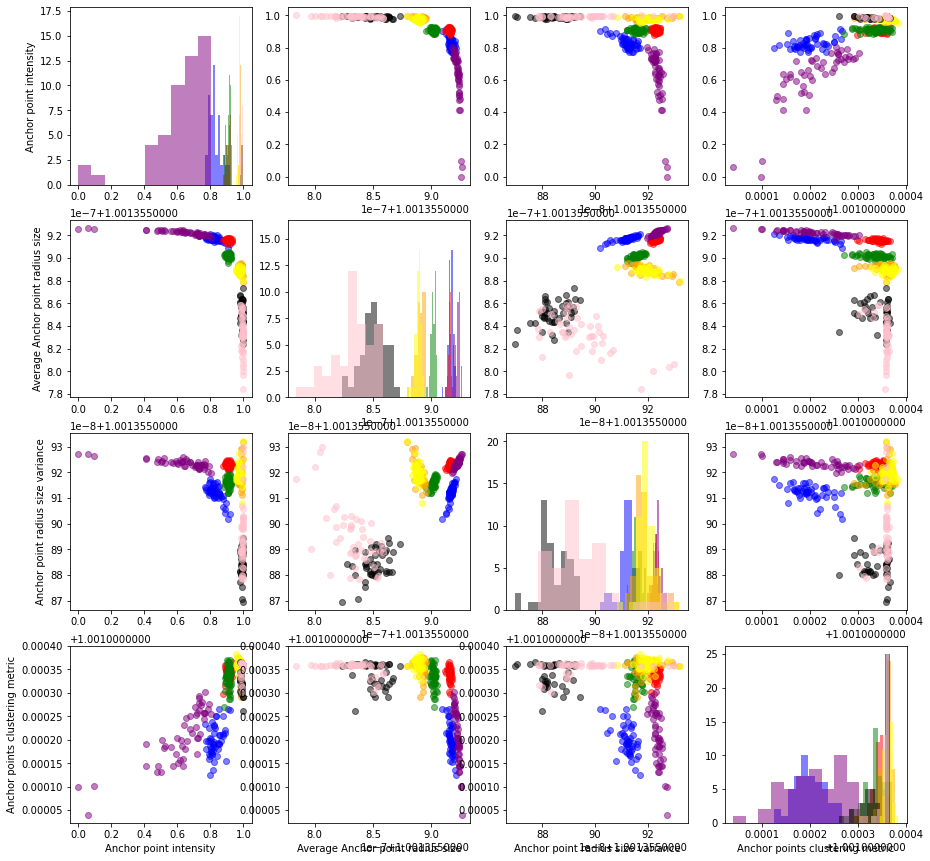

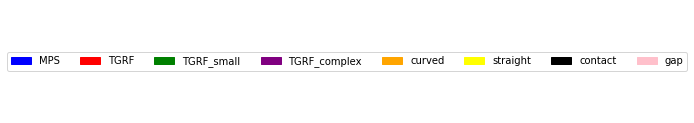

In [10]:
labels = ['Anchor point intensity', 'Average Anchor point radius size', 'Anchor point radius size variance', 'Anchor points clustering metric']
datanames = ['MPS', 'TGRF', 'TGRF_small', 'TGRF_complex', 'curved', 'straight', 'contact', 'gap']
some_colors = ['blue', 'red', 'green', 'purple', 'orange', 'yellow', 'black', 'pink']
subplot_dim = (4,4)
plotting_vecs(all_vectors,labels,datanames,some_colors,subplot_dim)

In [ ]:
max_feature_0 = np.max([np.max(np.array(OMRJ_vecs[i])[:,0]) for i in range(len(OMRJ_vecs))])
min_feature_0 = np.min([np.min(np.array(OMRJ_vecs[i])[:,0]) for i in range(len(OMRJ_vecs))])
max_feature_1 = np.max([np.max(np.array(OMRJ_vecs[i])[:,1]) for i in range(len(OMRJ_vecs))])
min_feature_1 = np.min([np.min(np.array(OMRJ_vecs[i])[:,1]) for i in range(len(OMRJ_vecs))])
max_feature_2 = np.max([np.max(np.array(OMRJ_vecs[i])[:,2]) for i in range(len(OMRJ_vecs))])
min_feature_2 = np.min([np.min(np.array(OMRJ_vecs[i])[:,2]) for i in range(len(OMRJ_vecs))])
max_feature_3 = np.max([np.max(np.array(OMRJ_vecs[i])[:,3]) for i in range(len(OMRJ_vecs))])
min_feature_3 = np.min([np.min(np.array(OMRJ_vecs[i])[:,3]) for i in range(len(OMRJ_vecs))])

In [ ]:
#Normalize all features to be between 0 and 1
OMRJ_vecs_normalized = []
for i in range(len(OMRJ_vecs)):
    vecs = []
    for j in range(len(OMRJ_vecs[i])):
        curr_vec = OMRJ_vecs[i][j]
        vecs.append(np.array([(curr_vec[0]-min_feature_0)/(max_feature_0-min_feature_0),(curr_vec[1]-min_feature_1)/(max_feature_1-min_feature_1) 
                                    ,(curr_vec[2]-min_feature_2)/(max_feature_2-min_feature_2) , (curr_vec[3]-min_feature_3)/(max_feature_3-min_feature_3)]))
    OMRJ_vecs_normalized.append(vecs)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
fig, axes = plt.subplots(4, 4, figsize=(15, 15))
fig.subplots_adjust(hspace=0.2, wspace=0.2)
labels = ['Anchor point intensity', 'Average inter-object anchor point density', 'Inter-object anchor point density variance', 'Anchor points Morans I']
datanames = ['MPS', 'TGRF', 'TGRF_small', 'TGRF_complex', 'curved', 'straight', 'contact', 'gap']
some_colors = ['blue', 'red', 'green', 'purple', 'orange', 'yellow', 'black', 'pink']
# Plot the data in matrix form
for i in range(4):
    for j in range(4):
        if i == j:
            for k in range(len(OMRJ_vecs_normalized)):
                axes[i, j].hist(np.array(OMRJ_vecs_normalized[k])[:,i],label=datanames[k],color=some_colors[k],alpha=0.5)
                #axes[i, j].legend()
        else:
            for k in range(len(OMRJ_vecs_normalized)):
                axes[i, j].scatter(np.array(OMRJ_vecs_normalized[k])[:,j], np.array(OMRJ_vecs_normalized[k])[:,i],label=datanames[k],color=some_colors[k],alpha=0.5)
                #axes[i, j].legend()
        if i == 3:
            axes[i, j].set_xlabel(labels[j])
        if j == 0:
            axes[i, j].set_ylabel(labels[i])

# Create a new figure for the legend
fig_legend, ax_legend = plt.subplots(figsize=(10, 2))  # Adjust the figure size to accommodate the horizontal legend

# Create legend handles manually
handles = [mpatches.Patch(color=some_colors[i], label=datanames[i]) for i in range(len(datanames))]

# Add the legend to the subplot
ax_legend.legend(handles=handles, loc='center', ncol=len(handles))

# Hide the axes
ax_legend.axis('off')

# Show the plots
plt.show()

In [ ]:
#from mpl_toolkits.axes_grid1 import make_axes_locatable
# Define the labels and data names
import matplotlib.lines as mlines


labels = ['Anchor point intensity', 'Average inter-object anchor point density', 'Inter-object anchor point density variance', 'Anchor points Morans I']
datanames = ['MPS', 'TGRF', 'TGRF_small', 'TGRF_complex', 'curved', 'straight', 'contact', 'gap']
some_colors = ['blue', 'red', 'green', 'purple', 'orange', 'yellow', 'black', 'pink']

# Create a 3D scatter plot
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')

# Define the marker styles
marker_styles = ['o', 'x', '^', 's', 'd', '+', 'v', '*']
# Extract data for the 3D scatter plot
for i in range(len(OMRJ_vecs_normalized)):
    long = np.array(OMRJ_vecs_normalized[i])[:, 0]
    lat = np.array(OMRJ_vecs_normalized[i])[:, 1]
    rural = np.array(OMRJ_vecs_normalized[i])[:, 2] 
    fatalities = np.array(OMRJ_vecs_normalized[i])[:, 3] 
    # Create the scatter plot
    scatter = ax.scatter(long, lat, rural, c=fatalities, cmap='viridis', s=40, alpha=0.6, label=datanames[i],marker=marker_styles[i])

# Reverse X-axis direction
ax.set_xlim(ax.get_xlim()[::-1])

# Set the view angle
ax.view_init(elev=14, azim=-31)

# Set labels
ax.set_xlabel(labels[0])
ax.set_ylabel(labels[1])
ax.set_zlabel(labels[2])

# Create and label the colorbar
cb = plt.colorbar(scatter, ax=ax)
cb.set_label(labels[3])
#set tick labels to be between 0 and 1, with 2 decimal places
cb.set_ticklabels(np.round(np.linspace(0,1,7),2))
#cb.set_ticklabels(np.linspace(0,1,7))
#cb.set_clim(0, 1)  # Manually set colorbar limits

# Show the plot
plt.show()

# Create a new figure for the legend
fig_legend, ax_legend = plt.subplots(figsize=(10, 2))  # Adjust the figure size to accommodate the horizontal legend

# Create legend handles manually
handles = [mlines.Line2D([], [], color='black', marker=marker_styles[i], linestyle='None', markersize=10, label=datanames[i]) for i in range(len(datanames))]

# Add the legend to the subplot
ax_legend.legend(handles=handles, loc='center', ncol=len(handles))

# Hide the axes
ax_legend.axis('off')

# Show the plots
plt.show()

# Compare to SSIM

In [ ]:
def comparison(vec1,vec2):
    comp = []
    for i in range(len(vec1)):
        calc = (vec1[i]-vec2[i])**2/np.max([vec1[i],vec2[i],vec1[i]-vec2[i]])**2
        comp.append(calc)
    comp = np.array(comp)
    return np.mean(comp)


comparison_df_pSSIM = pd.DataFrame(columns=['MPSvMPS','MPSvTGRF','MPSvTGRF_small','MPSvTGRF_complex','MPSvCurved','MPSvStraight','MPSvContact',
                                            'MPSvGap','TGRFvTGRF','TGRFvTGRF_small','TGRFvTGRF_complex','TGRFvCurved','TGRFvStraight','TGRFvContact','TGRFvGap',
                                            'TGRF_smallvTGRF_small','TGRF_smallvTGRF_complex','TGRF_smallvCurved','TGRF_smallvStraight','TGRF_smallvContact','TGRF_smallvGap',
                                            'TGRF_complexvTGRF_complex','TGRF_complexvCurved','TGRF_complexvStraight','TGRF_complexvContact','TGRF_complexvGap','CurvedvCurved',
                                            'CurvedvStraight','CurvedvContact','CurvedvGap','StraightvStraight','StraightvContact','StraightvGap','ContactvContact','ContactvGap','GapvGap'])
comparison_df_SSIM = pd.DataFrame(columns=['MPSvMPS','MPSvTGRF','MPSvTGRF_small','MPSvTGRF_complex','MPSvCurved','MPSvStraight','MPSvContact',
                                           'MPSvGap','TGRFvTGRF','TGRFvTGRF_small','TGRFvTGRF_complex','TGRFvCurved','TGRFvStraight','TGRFvContact','TGRFvGap',
                                           'TGRF_smallvTGRF_small','TGRF_smallvTGRF_complex','TGRF_smallvCurved','TGRF_smallvStraight','TGRF_smallvContact','TGRF_smallvGap',
                                           'TGRF_complexvTGRF_complex','TGRF_complexvCurved','TGRF_complexvStraight','TGRF_complexvContact','TGRF_complexvGap','CurvedvCurved',
                                           'CurvedvStraight','CurvedvContact','CurvedvGap','StraightvStraight','StraightvContact','StraightvGap','ContactvContact','ContactvGap','GapvGap'])

datanames = ['MPS', 'TGRF', 'TGRF_small', 'TGRF_complex', 'Curved', 'Straight', 'Contact', 'Gap']
# Make dataframes for the comparison, columns are SSIM: MPS vs MPS, MPS vs TGRF, MPS vs TGRF_small, MPS vs TGRF_complex, MPS vs curved, MPS vs straight, MPS vs contact, MPS vs gap, TGRF vs TGRF, TGRF vs TGRF_small, TGRF vs TGRF_complex, TGRF vs curved, TGRF vs straight, TGRF vs contact, TGRF vs gap, TGRF_small vs TGRF_small, TGRF_small vs TGRF_complex, TGRF_small vs curved, TGRF_small vs straight, TGRF_small vs contact, TGRF_small vs gap, TGRF_complex vs TGRF_complex, TGRF_complex vs curved, TGRF_complex vs straight, TGRF_complex vs contact, TGRF_complex vs gap, curved vs curved, curved vs straight, curved vs contact, curved vs gap, straight vs straight, straight vs contact, straight vs gap, contact vs contact, contact vs gap, gap vs gap
for i in range(len(OMRJ_vecs)):
    for j in range(i,len(OMRJ_vecs)):
        vecs_compared_pSSIM = np.full(2500,np.nan)
        vecs_compared_SSIM = np.full(2500,np.nan)
        for k in range(len(OMRJ_vecs[i])):
            for l in range(len(OMRJ_vecs[j])):
                if k != l:
                    if all_data[i][k].shape == all_data[j][l].shape:
                        img1 = all_data[i][k].astype(np.float64)
                        img2 = all_data[j][l].astype(np.float64)
                        vecs_compared_SSIM[int(k*50 + l)] = ssim(img1,img2,full=True,data_range = img1.max() - img1.min())[0]
                    vecs_compared_pSSIM[int(k*50 + l)] = comparison(OMRJ_vecs[i][k],OMRJ_vecs[j][l])
        comparison_df_pSSIM[datanames[i]+'v'+datanames[j]] = vecs_compared_pSSIM
        comparison_df_SSIM[datanames[i]+'v'+datanames[j]] = vecs_compared_SSIM
        
                    

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Reshape your data to long-form format

cols = ['blue','blue','blue','blue','blue','blue','blue','blue','red','red','red','red','red','red','red',
        'green','green','green','green','green','green','purple','purple','purple','purple','purple','orange',
        'orange','orange','orange','yellow','yellow','yellow','black','black','pink']
# Create a dictionary mapping each variable to a color
fig, axes = plt.subplots(4, 2, figsize=(35, 20))
for i in range(4):
    df_long = pd.melt(1 - comparison_df_pSSIM.iloc[:,int(9*i):int(9*(i+1))])
    color_dict = dict(zip(df_long['variable'].unique(), cols[int(9*i):int(9*(i+1))]))
    sns.violinplot(x='variable', y='value', data=df_long, palette=color_dict, ax=axes[i,0])
    axes[i,0].set_title('Violin plot of pSSIM values')
    axes[i,0].set_ylabel('pSSIM')
    axes[i,0].set_ylim(0,1)
    df_long = pd.melt(comparison_df_SSIM.iloc[:,int(9*i):int(9*(i+1))])
    color_dict = dict(zip(df_long['variable'].unique(), cols[int(9*i):int(9*(i+1))]))
    sns.violinplot(x='variable', y='value', data=df_long, palette=color_dict, ax=axes[i,1])
    axes[i,1].set_title('Violin plot of SSIM values')
    axes[i,1].set_ylabel('SSIM')
    axes[i,1].set_ylim(0,1)
plt.show()

In [ ]:
import gstools as gs
def make_TGRF(n_samples,var,len_scale,smoothness,grid_size,seed=2437):
    cov_model = gs.Matern(dim=2, var=var, len_scale=len_scale,nu=smoothness)
    srf = gs.SRF(cov_model)
    x = np.linspace(0, 1, grid_size)
    y = np.linspace(0, 1, grid_size)
    samples = np.zeros((n_samples,grid_size,grid_size))
    for i in range(n_samples):
        seed = seed + i
        GRF = srf.structured((x,y),seed=seed)
        sample = np.zeros_like(GRF)
        sample[GRF>1] = 1
        samples[i] = sample
        print("sample number: ", i, "out of ", n_samples)
    return samples

In [ ]:
grid_sizes = [50,100,200,500,1000]
grid_size_samples = []
for grid_size in grid_sizes:
    samples = make_TGRF(50,1,0.1,1,grid_size)
    fig, ax = plt.subplots(1, 5, figsize=(15, 3))
    for i in range(5):
        ax[i].imshow(samples[i], cmap='gray')
        ax[i].axis('off')
    plt.show()
    grid_size_samples.append(samples)

In [ ]:
#save the images
os.chdir('..')
os.chdir('Binary_images')
for i in range(len(grid_size_samples)):
    for j in range(len(grid_size_samples[i])):
        plt.imsave('TGRF_data_len_scale_' + str(i) + '_' + str(j) + '.png',grid_size_samples[i][j],cmap='gray')

OMRJ_grid_vecs = []
for i in range(len(grid_size_samples)):
    datum = []
    for j in range(len(grid_size_samples[i])):
        if np.sum(grid_size_samples[i][j]) > 0:
            datum.append(oscar_micky_vec(grid_size_samples[i][j]))
    OMRJ_grid_vecs.append(datum)

np.save('OMRJ_grid_vecs_small.npy',OMRJ_grid_vecs[0])
np.save('OMRJ_grid_vecs_medium.npy',OMRJ_grid_vecs[1])
np.save('OMRJ_grid_vecs_reg.npy',OMRJ_grid_vecs[2])
np.save('OMRJ_grid_vecs_large.npy',OMRJ_grid_vecs[3])
np.save('OMRJ_grid_vecs_xlarge.npy',OMRJ_grid_vecs[4])

max_feature_0 = np.max([np.max(np.array(OMRJ_grid_vecs[i])[:,0]) for i in range(len(OMRJ_grid_vecs))])
min_feature_0 = np.min([np.min(np.array(OMRJ_grid_vecs[i])[:,0]) for i in range(len(OMRJ_grid_vecs))])
max_feature_1 = np.max([np.max(np.array(OMRJ_grid_vecs[i])[:,1]) for i in range(len(OMRJ_grid_vecs))])
min_feature_1 = np.min([np.min(np.array(OMRJ_grid_vecs[i])[:,1]) for i in range(len(OMRJ_grid_vecs))])
max_feature_2 = np.max([np.max(np.array(OMRJ_grid_vecs[i])[:,2]) for i in range(len(OMRJ_grid_vecs))])
min_feature_2 = np.min([np.min(np.array(OMRJ_grid_vecs[i])[:,2]) for i in range(len(OMRJ_grid_vecs))])
max_feature_3 = np.max([np.max(np.array(OMRJ_grid_vecs[i])[:,3]) for i in range(len(OMRJ_grid_vecs))])
min_feature_3 = np.min([np.min(np.array(OMRJ_grid_vecs[i])[:,3]) for i in range(len(OMRJ_grid_vecs))])
OMRJ_grid_vecs_normalized = []
for i in range(len(OMRJ_grid_vecs)):
    vecs = []
    for j in range(len(OMRJ_grid_vecs[i])):
        curr_vec = OMRJ_grid_vecs[i][j]
        vecs.append(np.array([(curr_vec[0]-min_feature_0)/(max_feature_0-min_feature_0),(curr_vec[1]-min_feature_1)/(max_feature_1-min_feature_1) 
                                    ,(curr_vec[2]-min_feature_2)/(max_feature_2-min_feature_2) , (curr_vec[3]-min_feature_3)/(max_feature_3-min_feature_3)]))
    OMRJ_grid_vecs_normalized.append(vecs)

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
fig, axes = plt.subplots(4, 4, figsize=(15, 15))
fig.subplots_adjust(hspace=0.2, wspace=0.2)
labels = ['Anchor point intensity', 'Average inter-object anchor point density', 'Inter-object anchor point density variance', 'Anchor points Morans I']
datanames = ['TGRF_small', 'TGRF_med', 'TGRF_reg', 'TGRF_larg', 'TGRF_big']
some_colors = ['blue', 'red', 'green', 'purple', 'orange', 'yellow', 'black', 'pink']
# Plot the data in matrix form
for i in range(4):
    for j in range(4):
        if i == j:
            for k in range(len(OMRJ_grid_vecs_normalized)):
                axes[i, j].hist(np.array(OMRJ_grid_vecs_normalized[k])[:,i],label=datanames[k],color=some_colors[k],alpha=0.5)
                #axes[i, j].legend()
        else:
            for k in range(len(OMRJ_grid_vecs)):
                axes[i, j].scatter(np.array(OMRJ_grid_vecs_normalized[k])[:,j], np.array(OMRJ_grid_vecs_normalized[k])[:,i],label=datanames[k],color=some_colors[k],alpha=0.5)
                #axes[i, j].legend()
        if i == 3:
            axes[i, j].set_xlabel(labels[j])
        if j == 0:
            axes[i, j].set_ylabel(labels[i])

# Create a new figure for the legend
fig_legend, ax_legend = plt.subplots(figsize=(10, 2))  # Adjust the figure size to accommodate the horizontal legend

# Create legend handles manually
handles = [mpatches.Patch(color=some_colors[i], label=datanames[i]) for i in range(len(datanames))]

# Add the legend to the subplot
ax_legend.legend(handles=handles, loc='center', ncol=len(handles))

# Hide the axes
ax_legend.axis('off')

# Show the plots
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
# Create realizations with different length scales
len_scales = [0.01,0.05,0.1,0.2,0.5]
len_scale_samples = []
for len_scale in len_scales:
    samples = make_TGRF(200,1.0,len_scale,1,500)
    fig, ax = plt.subplots(1, 5, figsize=(15, 3))
    for i in range(5):
        ax[i].imshow(samples[i], cmap='gray')
        ax[i].axis('off')
    plt.show()
    len_scale_samples.append(samples)


In [ ]:
#save the images
os.chdir('..')
os.chdir('Binary_images')
for i in range(len(len_scale_samples)):
    for j in range(len(len_scale_samples[i])):
        plt.imsave('TGRF_data_len_scale_' + str(i) + '_' + str(j) + '.png',len_scale_samples[i][j],cmap='gray')

In [ ]:
OMRJ_len_vecs = []
for i in range(len(len_scale_samples)):
    datum = []
    for j in range(len(len_scale_samples[i])):
        if np.sum(len_scale_samples[i][j]) > 0:
            datum.append(oscar_micky_vec(len_scale_samples[i][j]))
    OMRJ_len_vecs.append(datum)

In [ ]:
os.chdir('Anchors 3')

In [ ]:
#save the omrj vectors
#os.chdir('..')
#os.chdir('Vectors')
np.save('OMRJ_len_vecs_small.npy',OMRJ_len_vecs[0])
np.save('OMRJ_len_vecs_medium.npy',OMRJ_len_vecs[1])
np.save('OMRJ_len_vecs_reg.npy',OMRJ_len_vecs[2])
np.save('OMRJ_len_vecs_large.npy',OMRJ_len_vecs[3])
np.save('OMRJ_len_vecs_xlarge.npy',OMRJ_len_vecs[4])


In [ ]:
#Normalize all features to be between 0 and 1
max_feature_0 = np.max([np.max(np.array(OMRJ_len_vecs[i])[:,0]) for i in range(len(OMRJ_len_vecs))])
min_feature_0 = np.min([np.min(np.array(OMRJ_len_vecs[i])[:,0]) for i in range(len(OMRJ_len_vecs))])
max_feature_1 = np.max([np.max(np.array(OMRJ_len_vecs[i])[:,1]) for i in range(len(OMRJ_len_vecs))])
min_feature_1 = np.min([np.min(np.array(OMRJ_len_vecs[i])[:,1]) for i in range(len(OMRJ_len_vecs))])
max_feature_2 = np.max([np.max(np.array(OMRJ_len_vecs[i])[:,2]) for i in range(len(OMRJ_len_vecs))])
min_feature_2 = np.min([np.min(np.array(OMRJ_len_vecs[i])[:,2]) for i in range(len(OMRJ_len_vecs))])
max_feature_3 = np.max([np.max(np.array(OMRJ_len_vecs[i])[:,3]) for i in range(len(OMRJ_len_vecs))])
min_feature_3 = np.min([np.min(np.array(OMRJ_len_vecs[i])[:,3]) for i in range(len(OMRJ_len_vecs))])
OMRJ_len_vecs_normalized = []
for i in range(len(OMRJ_len_vecs)):
    vecs = []
    for j in range(len(OMRJ_len_vecs[i])):
        curr_vec = OMRJ_len_vecs[i][j]
        vecs.append(np.array([(curr_vec[0]-min_feature_0)/(max_feature_0-min_feature_0),(curr_vec[1]-min_feature_1)/(max_feature_1-min_feature_1) 
                                    ,(curr_vec[2]-min_feature_2)/(max_feature_2-min_feature_2) , (curr_vec[3]-min_feature_3)/(max_feature_3-min_feature_3)]))
    OMRJ_len_vecs_normalized.append(vecs)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
fig, axes = plt.subplots(4, 4, figsize=(15, 15))
fig.subplots_adjust(hspace=0.2, wspace=0.2)
labels = ['Anchor point intensity', 'Average inter-object anchor point density', 'Inter-object anchor point density variance', 'Anchor points Morans I']
datanames = ['TGRF_small', 'TGRF_med', 'TGRF_reg', 'TGRF_larg', 'TGRF_big']
some_colors = ['blue', 'red', 'green', 'purple', 'orange', 'yellow', 'black', 'pink']
# Plot the data in matrix form
for i in range(4):
    for j in range(4):
        if i == j:
            for k in range(len(OMRJ_len_vecs_normalized)):
                axes[i, j].hist(np.array(OMRJ_len_vecs_normalized[k])[:,i],label=datanames[k],color=some_colors[k],alpha=0.5)
                #axes[i, j].legend()
        else:
            for k in range(len(OMRJ_len_vecs)):
                axes[i, j].scatter(np.array(OMRJ_len_vecs_normalized[k])[:,j], np.array(OMRJ_len_vecs_normalized[k])[:,i],label=datanames[k],color=some_colors[k],alpha=0.5)
                #axes[i, j].legend()
        if i == 3:
            axes[i, j].set_xlabel(labels[j])
        if j == 0:
            axes[i, j].set_ylabel(labels[i])

# Create a new figure for the legend
fig_legend, ax_legend = plt.subplots(figsize=(10, 2))  # Adjust the figure size to accommodate the horizontal legend

# Create legend handles manually
handles = [mpatches.Patch(color=some_colors[i], label=datanames[i]) for i in range(len(datanames))]

# Add the legend to the subplot
ax_legend.legend(handles=handles, loc='center', ncol=len(handles))

# Hide the axes
ax_legend.axis('off')

# Show the plots
plt.show()

In [ ]:
#from mpl_toolkits.axes_grid1 import make_axes_locatable
# Define the labels and data names
import matplotlib.lines as mlines


labels = ['Anchor point intensity', 'Average inter-object anchor point density', 'Inter-object anchor point density variance', 'Anchor points Morans I']
datanames = ['TGRF_small', 'TGRF_med', 'TGRF_reg', 'TGRF_larg', 'TGRF_big']
some_colors = ['blue', 'red', 'green', 'purple', 'orange', 'yellow', 'black', 'pink']

# Create a 3D scatter plot
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')

# Define the marker styles
marker_styles = ['o', 'x', '^', 's', 'd', '+', 'v', '*']
# Extract data for the 3D scatter plot
for i in range(len(OMRJ_len_vecs_normalized)):
    long = np.array(OMRJ_len_vecs_normalized[i])[:, 0]
    lat = np.array(OMRJ_len_vecs_normalized[i])[:, 1]
    rural = np.array(OMRJ_len_vecs_normalized[i])[:, 2] 
    fatalities = np.array(OMRJ_len_vecs_normalized[i])[:, 3] 
    # Create the scatter plot
    scatter = ax.scatter(long, lat, rural, c=fatalities, cmap='viridis', s=40, alpha=0.6, label=datanames[i],marker=marker_styles[i])

# Reverse X-axis direction
ax.set_xlim(ax.get_xlim()[::-1])

# Set the view angle
ax.view_init(elev=14, azim=-31)

# Set labels
ax.set_xlabel(labels[0])
ax.set_ylabel(labels[1])
ax.set_zlabel(labels[2])

# Create and label the colorbar
cb = plt.colorbar(scatter, ax=ax)
cb.set_label(labels[3])
#set tick labels to be between 0 and 1, with 2 decimal places
cb.set_ticklabels(np.round(np.linspace(0,1,7),2))
#cb.set_ticklabels(np.linspace(0,1,7))
#cb.set_clim(0, 1)  # Manually set colorbar limits

# Show the plot
plt.show()

# Create a new figure for the legend
fig_legend, ax_legend = plt.subplots(figsize=(10, 2))  # Adjust the figure size to accommodate the horizontal legend

# Create legend handles manually
handles = [mlines.Line2D([], [], color='black', marker=marker_styles[i], linestyle='None', markersize=10, label=datanames[i]) for i in range(len(datanames))]

# Add the legend to the subplot
ax_legend.legend(handles=handles, loc='center', ncol=len(handles))

# Hide the axes
ax_legend.axis('off')

# Show the plots
plt.show()

In [ ]:
OMRJ_len_vecs_normalized[0]

In [ ]:
def comparison(vec1,vec2):
    comp = []
    for i in range(len(vec1)):
        calc = (vec1[i]-vec2[i])**2/np.max([vec1[i],vec2[i],vec1[i]-vec2[i]])**2
        comp.append(calc)
    comp = np.array(comp)
    return np.mean(comp)


comparison_df_pSSIM = pd.DataFrame(columns=['SmallvSmall','SmallvMed','SmallvReg','SmallvLarg','SmallvBig','MedvMed','MedvReg',
                                            'MedvLarg','MedvBig','RegvReg','RegvLarg','RegvBig','LargvLarg','LargvBig','BigvBig'])
comparison_df_SSIM = pd.DataFrame(columns=['SmallvSmall','SmallvMed','SmallvReg','SmallvLarg','SmallvBig','MedvMed','MedvReg',
                                           'MedvLarg','MedvBig','RegvReg','RegvLarg','RegvBig','LargvLarg','LargvBig','BigvBig'])

datanames = ['Small', 'Med', 'Reg', 'Larg', 'Big']
for i in range(len(OMRJ_len_vecs_normalized)):
    for j in range(i,len(OMRJ_len_vecs_normalized)):
        vecs_compared_pSSIM = np.full(200*200+1,np.nan)
        vecs_compared_SSIM = np.full(200*200+1,np.nan)
        for k in range(len(OMRJ_len_vecs_normalized[i])):
            for l in range(len(OMRJ_len_vecs_normalized[j])):
                if k != l:
                    if len_scale_samples[i][k].shape == len_scale_samples[j][l].shape:
                        img1 = len_scale_samples[i][k].astype(np.float64)
                        img2 = len_scale_samples[j][l].astype(np.float64)
                        vecs_compared_SSIM[int(k*200 + l)] = ssim(img1,img2,full=True,data_range = img1.max() - img1.min())[0]
                    vecs_compared_pSSIM[int(k*200 + l)] = comparison(OMRJ_len_vecs_normalized[i][k],OMRJ_len_vecs_normalized[j][l])
        comparison_df_pSSIM[datanames[i]+'v'+datanames[j]] = vecs_compared_pSSIM
        comparison_df_SSIM[datanames[i]+'v'+datanames[j]] = vecs_compared_SSIM
        
                    

In [ ]:
comparison_df_SSIM

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Reshape your data to long-form format

cols = ['blue','blue','blue','blue','blue','red','red','red','red','green','green','green','purple','purple','purple','orange']
# Create a dictionary mapping each variable to a color
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
for i in range(2):
    df_long = pd.melt(1 - comparison_df_pSSIM.iloc[:,int(9*i):int(9*(i+1))])
    color_dict = dict(zip(df_long['variable'].unique(), cols[int(9*i):int(9*(i+1))]))
    sns.violinplot(x='variable', y='value', data=df_long, palette=color_dict, ax=axes[i,0])
    axes[i,0].set_title('Violin plot of pSSIM values')
    axes[i,0].set_ylabel('pSSIM')
    axes[i,0].set_ylim(0,1)
    df_long = pd.melt(comparison_df_SSIM.iloc[:,int(9*i):int(9*(i+1))])
    color_dict = dict(zip(df_long['variable'].unique(), cols[int(9*i):int(9*(i+1))]))
    sns.violinplot(x='variable', y='value', data=df_long, palette=color_dict, ax=axes[i,1])
    axes[i,1].set_title('Violin plot of SSIM values')
    axes[i,1].set_ylabel('SSIM')
    axes[i,1].set_ylim(0,1)
plt.show()

In [ ]:
# Save the data as .png
os.chdir('..')
os.chdir('Binary_images')
for i in range(50):
    plt.imsave('TGRF_small_len_scale' + str(i) + '.png', len_scale_samples[0][i], cmap='gray')
    plt.imsave('TGRF_med_scale' + str(i) + '.png', len_scale_samples[1][i], cmap='gray')
    plt.imsave('TGRF_reg_len_scale' + str(i) + '.png', len_scale_samples[2][i], cmap='gray')
    plt.imsave('TGRF_larg_len_scale' + str(i) + '.png', len_scale_samples[3][i], cmap='gray')
    plt.imsave('TGRF_big_len_scale' + str(i) + '.png', len_scale_samples[4][i], cmap='gray')

In [ ]:
image_paths_low = []
image_paths_med = []
image_paths_reg = []
image_paths_larg = []
image_paths_big = []
os.chdir('..')
os.chdir('Binary_images')
for i in range(50):
    image_paths_low.append(os.path.join(os.getcwd(),'TGRF_small_len_scale' + str(i) + '.png'))
    image_paths_med.append(os.path.join(os.getcwd(),'TGRF_med_scale' + str(i) + '.png'))
    image_paths_reg.append(os.path.join(os.getcwd(),'TGRF_reg_len_scale' + str(i) + '.png'))
    image_paths_larg.append(os.path.join(os.getcwd(),'TGRF_larg_len_scale' + str(i) + '.png'))
    image_paths_big.append(os.path.join(os.getcwd(),'TGRF_big_len_scale' + str(i) + '.png'))

image_paths = [image_paths_low, image_paths_med, image_paths_reg, image_paths_larg, image_paths_big[:47]]
datanames = ['TGRF_small', 'TGRF_med', 'TGRF_reg', 'TGRF_larg', 'TGRF_big']

In [ ]:
scatter_plot_with_images_update(OMRJ_len_vecs, image_paths, datanames, filename='OMRJ_scatter_plot_with_images.html')